In [1]:
import numpy as np
from numpy.typing import NDArray
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from typing import List, Tuple

from type_definitions.test_case import TestCase
from type_definitions.test_result import TestResult
from type_definitions.utils import *

In [2]:
seed = 100
np.random.seed(seed)

cases = generate_cases(500)
results = evaluate_cases(cases)
trajectories = [r.trajectory for r in results if not r.simulation_failed]
valid_results = [r for r in results if not r.simulation_failed]

print(f"Generated {len(trajectories)} valid trajectories")
print(
    f"Crashed: {sum(1 for r in valid_results if r.crashed)}, Safe: {sum(1 for r in valid_results if not r.crashed)}"
)

Generated 149 valid trajectories
Crashed: 25, Safe: 124


In [3]:
distance_matrix_file = f"cache/distance_matrix_seed{seed}_size{len(trajectories)}.npy"

if os.path.exists(distance_matrix_file):
    print(f"Loading distance matrix from {distance_matrix_file}")
    distance_matrix = np.load(distance_matrix_file)
else:
    print("Calculating pairwise distances...")
    distance_matrix = pairwise_distances(trajectories)
    np.save(distance_matrix_file, distance_matrix)
    print(f"Distance matrix saved to {distance_matrix_file}")

print(f"Distance matrix shape: {distance_matrix.shape}")

Loading distance matrix from cache/distance_matrix_seed100_size149.npy
Distance matrix shape: (149, 149)


In [4]:
def testcase_to_ndarray(test_case: TestCase) -> np.ndarray:

    return np.array(
        [
            test_case.vt,
            test_case.alpha,
            test_case.beta,
            test_case.phi,
            test_case.theta,
            test_case.psi,
            test_case.alt,
            test_case.power,
        ]
    )


test_cases = [r.test_case for r in valid_results]
features = np.array([testcase_to_ndarray(case) for case in test_cases])
features.shape

(149, 8)

In [5]:
def create_pairwise_features(
    features: NDArray[np.float64], distance_matrix: NDArray[np.float64]
) -> Tuple[NDArray[np.float64], NDArray[np.float64]]:
    n = features.shape[0]
    pairwise_features = []
    distances = []

    # Use upper triangular matrix to avoid duplicates
    for i in range(n):
        for j in range(i + 1, n):
            # Feature differences
            feat_diff = features[i] - features[j]
            feat_abs_diff = np.abs(feat_diff)

            # Additional features
            euclidean_dist = np.linalg.norm(feat_diff)

            # Angular differences for angles (alpha, beta, phi, theta, psi)
            angular_indices = [1, 2, 3, 4, 5]  # alpha, beta, phi, theta, psi
            angular_diffs = []
            for idx in angular_indices:
                diff = feat_diff[idx]
                # Normalize to [-pi, pi]
                while diff > np.pi:
                    diff -= 2 * np.pi
                while diff < -np.pi:
                    diff += 2 * np.pi
                angular_diffs.append(diff)

            # Combine all features
            combined_features = np.concatenate(
                [
                    feat_diff,
                    feat_abs_diff,
                    [euclidean_dist],
                    angular_diffs,
                ]
            )

            pairwise_features.append(combined_features)
            distances.append(distance_matrix[i, j])

    return np.array(pairwise_features), np.array(distances)


X, y = create_pairwise_features(features, distance_matrix)

print(f"Pairwise features shape: {X.shape}")
print(f"Distances shape: {y.shape}")

Pairwise features shape: (11026, 22)
Distances shape: (11026,)


In [6]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Training set: 8820 samples
Test set: 2206 samples


In [7]:
# Train Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=20, random_state=seed, n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
# Make predictions
rf_predictions = rf_model.predict(X_test_scaled)

rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = rf_model.score(X_test_scaled, y_test)


print(f"MAE: {rf_mae:.2f}")
print(f"RMSE: {rf_rmse:.2f}")
print(f"R squared: {rf_r2:.4f}")

MAE: 1844.99
RMSE: 2602.56
R squared: 0.6169


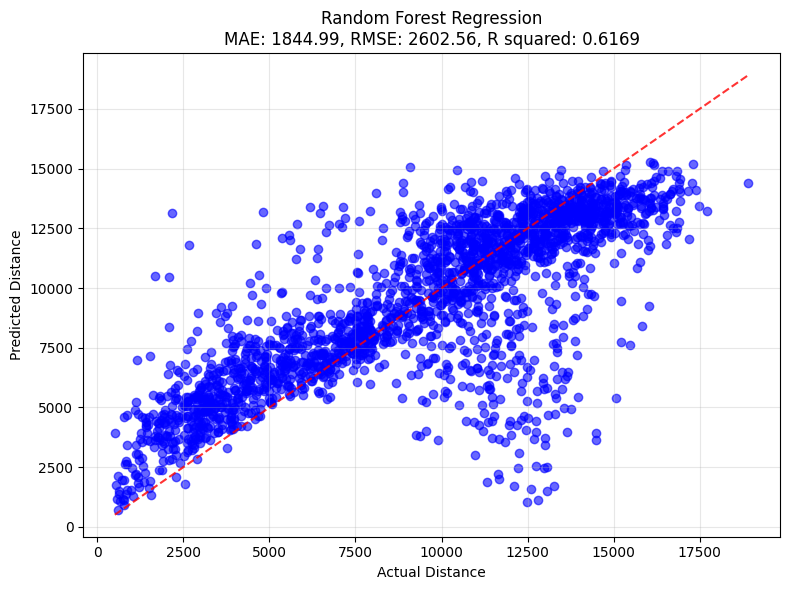

In [9]:
# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(y_test, rf_predictions, alpha=0.6, color="blue")
min_val = min(y_test.min(), rf_predictions.min())
max_val = max(y_test.max(), rf_predictions.max())
ax.plot([min_val, max_val], [min_val, max_val], "r--", alpha=0.8)
ax.set_xlabel("Actual Distance")
ax.set_ylabel("Predicted Distance")
ax.set_title(
    f"Random Forest Regression\nMAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}, R squared: {rf_r2:.4f}"
)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Feature importance analysis
feature_names = [
    "vt_diff",
    "alpha_diff",
    "beta_diff",
    "phi_diff",
    "theta_diff",
    "psi_diff",
    "alt_diff",
    "power_diff",
    "vt_abs_diff",
    "alpha_abs_diff",
    "beta_abs_diff",
    "phi_abs_diff",
    "theta_abs_diff",
    "psi_abs_diff",
    "alt_abs_diff",
    "power_abs_diff",
    "euclidean_dist",
    "alpha_angular_diff",
    "beta_angular_diff",
    "phi_angular_diff",
    "theta_angular_diff",
    "psi_angular_diff",
]

# Get feature importances
rf_importances = rf_model.feature_importances_

# Sort features by importance
rf_indices = np.argsort(rf_importances)[::-1]

print("Top 10 Most Important Features:")
for i in range(min(10, len(feature_names))):
    idx = rf_indices[i]
    print(f"  {i+1}. {feature_names[idx]}: {rf_importances[idx]:.4f}")

Top 10 Most Important Features:
  1. phi_abs_diff: 0.6186
  2. vt_abs_diff: 0.0518
  3. vt_diff: 0.0494
  4. theta_abs_diff: 0.0313
  5. alt_diff: 0.0285
  6. beta_abs_diff: 0.0236
  7. alpha_abs_diff: 0.0235
  8. phi_diff: 0.0201
  9. phi_angular_diff: 0.0194
  10. theta_diff: 0.0188
